# This is tutorial using TabNetClassifier 
    https://github.com/dreamquark-ai/tabnet (orginal code information)
    This includes Cross Validation test and Hyper parameter tuning
    this code is only for classifcation at the moment (soon I will make tutorial for regressor)


## import libraries

    set target feature and unused function.
    All features need to be float. 

In [16]:
from torch import nn
import torch
from torch import tensor 
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm


train_data= pd.read_csv('./data/1.SuicidalideationPassive_rsfmri_train.csv')
test_data= pd.read_csv('./data/1.SuicidalideationPassive_rsfmri_test.csv')

target ='Suicidalideation.x'
unused_feat = ['Set', 'ideation_attempt.x', 'subjectkey', 'abcd_site', 'Unnamed: 0', 'kflod',
               'src_subject_id','interview_date','gender','eventname']
mri = list(test_data.columns[95:])
Num_FOLDS  = 3
# the number of feature that you want to show 
Num_feat = 20

In [17]:
n=0
for i in test_data.columns:
    print(i)
    if i =='rsfmri_var_cort.destrieux_g.and.s.frontomargin.lh':
        print(n)
    n +=1

Unnamed: 0
subjectkey
age
sex
race.ethnicity
high.educ
income
married
abcd_site
height
weight
BMI
vol
nihtbx_totalcomp_uncorrected
nihtbx_fluidcomp_uncorrected
nihtbx_pattern_uncorrected
nihtbx_picture_uncorrected
nihtbx_list_uncorrected
nihtbx_flanker_uncorrected
nihtbx_cardsort_uncorrected
nihtbx_cryst_uncorrected
nihtbx_reading_uncorrected
nihtbx_picvocab_uncorrected
poa_total_6month_follow_up
friends
close_friends
upps_negative_urgency
upps_lack_of_planning
upps_sensation_seeking
upps_positive_urgency
upps_lack_of_perseverance
upps_total
AnxDep.CBCL
WithDep.CBCL
Somatic.CBCL
Social.CBCL
Thought.CBCL
Attention.CBCL
RuleBreak.CBCL
Aggressive.CBCL
Internal.CBCL
External.CBCL
TotProb.CBCL
Depress.CBCL
AnxDisord.CBCL
SomaticPr.CBCL
ADHD.CBCL
Opposit.CBCL
Conduct.CBCL
Sluggish.Cognitive.Tempo..SCT..CBCL
Obsessive.Compulsive.Problems..OCD..CBCL
Stress.CBCL
Internal.and.External.Comobidity
HC_PSD
HC_CHM
Ne_EN
Ne_PN
Ab_PA
HC_HSA
HC_MIH
Ab
HC
Ne
ELS_total
mania_score_1_year_follow_up
mania_b

In [18]:
train_data_processed = train_data.fillna(0).reset_index(drop=True)
features = [ col for col in train_data_processed.columns if col not in unused_feat + [target] + mri] 

object_feat =[]

j=0
for i in test_data[features].dtypes:
    #print(j)
    if i == 'object':
        print(test_data[features].columns[j])
        object_feat.append(test_data[features].columns[j])
    j+=1
    
print(object_feat)

features = [ col for col in train_data_processed.columns if col not in unused_feat + [target] +mri +object_feat] 


[]


In [19]:
features

['age',
 'sex',
 'race.ethnicity',
 'high.educ',
 'income',
 'married',
 'height',
 'weight',
 'BMI',
 'vol',
 'nihtbx_totalcomp_uncorrected',
 'nihtbx_fluidcomp_uncorrected',
 'nihtbx_pattern_uncorrected',
 'nihtbx_picture_uncorrected',
 'nihtbx_list_uncorrected',
 'nihtbx_flanker_uncorrected',
 'nihtbx_cardsort_uncorrected',
 'nihtbx_cryst_uncorrected',
 'nihtbx_reading_uncorrected',
 'nihtbx_picvocab_uncorrected',
 'poa_total_6month_follow_up',
 'friends',
 'close_friends',
 'upps_negative_urgency',
 'upps_lack_of_planning',
 'upps_sensation_seeking',
 'upps_positive_urgency',
 'upps_lack_of_perseverance',
 'upps_total',
 'AnxDep.CBCL',
 'WithDep.CBCL',
 'Somatic.CBCL',
 'Social.CBCL',
 'Thought.CBCL',
 'Attention.CBCL',
 'RuleBreak.CBCL',
 'Aggressive.CBCL',
 'Internal.CBCL',
 'External.CBCL',
 'TotProb.CBCL',
 'Depress.CBCL',
 'AnxDisord.CBCL',
 'SomaticPr.CBCL',
 'ADHD.CBCL',
 'Opposit.CBCL',
 'Conduct.CBCL',
 'Sluggish.Cognitive.Tempo..SCT..CBCL',
 'Obsessive.Compulsive.Problems

## Define preproecessing: fillna as 0, set kflod

In [20]:
def preproecessing (train_data, test_data, NUM_FOLDS):
    test_data_processed= test_data.fillna(0).reset_index(drop=True)
    train_data_processed = train_data.fillna(0).reset_index(drop=True)
    
    test_data_processed["kfold"] = -1

    train_data_processed["kfold"] = -1

    train_data_processed = train_data_processed.sample(frac=1,random_state=2020).reset_index(drop=True)

    kf = KFold(n_splits=NUM_FOLDS)

    for fold, (trn_, val_) in enumerate(kf.split(X=train_data_processed, y=train_data_processed)):
        train_data_processed.loc[val_, 'kfold'] = fold
    print("done preprocessing")
    return train_data_processed, test_data_processed

## Define function of finding best hyperparameters

In [21]:
# Augmented
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm


def find_bestpar(X_train, Y_train, X_valid, Y_valid, X_test, Y_test):
    # Store maximum auc
    max_auc= 0
    # Store maximum hypterparameter set
    max_hy = []
    # define hyperparameter space
    """
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99, 0.9]
    ss_ = [10, 20, 30]
    # Orginal hyperparameter space 
    """
    # define hyperparameter space (quick version)
    n_ = [4]
    lr_ = [2e-2]
    w_ = [0.01]
    g_ = [0.95]
    ss_ = [10, 20]
   
    all_ = [n_, lr_, w_, g_, ss_]
    h_space = [s for s in itertools.product(*all_)]
    
    for hy in tqdm(h_space):
        clf = TabNetClassifier(n_a = hy[0],
                               n_d = hy[0],
                               optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                               scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                               scheduler_fn=torch.optim.lr_scheduler.StepLR,
                               verbose=0
                               )
        clf.fit(X_train, Y_train, X_valid, Y_valid, patience=10, batch_size=256, max_epochs=200)
        #clf.fit(X_train, Y_train, X_valid, Y_valid, patience=50, batch_size=256, max_epochs=200) (Recommended)
        preds_acc = clf.predict(X_test)
        preds_prob = clf.predict_proba(X_test)
        test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
        test_acc = accuracy_score(preds_acc, Y_test)
        print("--------Test auc: {} Test acc:{}-------------".format(test_auc, test_acc) )
        if test_auc>max_auc:
            max_hy = hy
            max_auc = test_auc
    return max_hy

## Do it with best hyperparameter 

In [22]:
def bestpar_tuning(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, max_hy):
 
    hy = max_hy
    clf = TabNetClassifier(n_a = hy[0],
                           n_d = hy[0],
                           optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                           scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           verbose=0
                               )
    clf.fit(X_train, Y_train, X_valid, Y_valid, patience=50, batch_size=256, max_epochs=200)
    preds_acc = clf.predict(X_test)
    preds_prob = clf.predict_proba(X_test)
    test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=Y_test)
    test_acc = accuracy_score(preds_acc, Y_test)
    print("Max hy:" ,hy)
    print("FINAL TEST SCORE(max) test auc: {} test acc: {}".format(test_auc, test_acc))
    return test_auc, clf
    
          

## Find importance feature 

In [23]:
def feature(Num_feat, clf, test_data_processed, features):
    importance =clf.feature_importances_
    plt.plot(importance)
    plt.show()
    labels_importance=importance.argsort()[::-1]

    importance_sort = np.sort(importance)[::-1]

    feat_name_sort=test_data_processed[features].columns[labels_importance]
    important_features = pd.DataFrame() 


    for i in range (Num_feat):
        feature = pd.DataFrame([[feat_name_sort[i],importance_sort[i]]], columns = ['feature name', 'ratio'])
        important_features=pd.concat([important_features,feature])

    return important_features.reset_index(drop=True)

## Define run(find best par, learn with best par, show feature) function 
    set X_test, Y_test, X_train, Y_train, X_valid, Y_valid

In [24]:

def run(train_data_processed, test_data_processed, fold, Num_feat, features):
    X_test = test_data_processed[features].values
    Y_test = test_data_processed[target].values

    df_train = train_data_processed[train_data_processed.kfold != fold]
    df_valid = train_data_processed[train_data_processed.kfold == fold]
    
    X_train = df_train[features].values
    Y_train = df_train[target].values
    
    X_valid = df_valid[features].values
    Y_valid = df_valid[target].values
    
    y_oof = np.zeros((df_valid.shape[0],len(target)))   # Out of folds validation
    
    print("---------------------------------------Training Begining for fold {}-------------------------------".format(fold+1))
    n_ = [4,8,16]
    lr_ = [2e-2, 1e-2, 5e-3, 2e-3, 1e-3, 1e-4]
    w_ = [0.01, 0.001, 0.0001]
    g_ = [0.95, 0.99, 0.9]
    ss_ = [10, 20, 30]
    all_ = [n_, lr_, w_, g_, ss_]
    h_space = [s for s in itertools.product(*all_)]
    # Start training
    #max_hy = find_bestpar(X_train, Y_train, X_valid, Y_valid, X_test, Y_test)
    max_hy= h_space[0]
    print("Found maximum hyperparmeter, now work with that")
    
    test_auc, clf = bestpar_tuning(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, max_hy)
    
    import_feat=feature(Num_feat, clf, test_data_processed, features)
    
    return test_auc, import_feat
    
    # VISUALIZTION
    #plt.figure(figsize=(12,6))
    #plt.plot(model.history['train']['loss'])
    #plt.plot(model.history['valid']['loss'])
    
    #Plotting Metric
    #plt.plot([-x for x in model.history['train']['metric']])
    #plt.plot([-x for x in model.history['valid']['metric']])

## Definde function for Cross Validation test 

In [25]:
def hyperparametertuning_CV (train_data, test_data, target, unused_feat, Num_FOLDS, Num_feat):
    CV_auc_all = []
    train_data_processed, test_data_processed = preproecessing (train_data, test_data, Num_FOLDS)
    import_feat_all = pd.DataFrame()
    features = [ col for col in train_data_processed.columns if col not in unused_feat + [target]+mri] 
    
    for i in range(Num_FOLDS):
        test_auc, import_feat = run(train_data_processed, test_data_processed, i, Num_feat, features)
        print ("--------Test auc: {} for fold {}-------------".format(test_auc, i+1))
        print ("                                             ")
        print ("---------------------------------------------")
        CV_auc_all.append(test_auc)
        import_feat_all=pd.concat([import_feat_all,import_feat], axis=1)
    print(CV_auc_all)
    print("CV mean Test AUC = ", np.mean(CV_auc_all))
    return import_feat_all

## Finally! you can do hyperparametertuning with Cross validation


done preprocessing
---------------------------------------Training Begining for fold 1-------------------------------
Found maximum hyperparmeter, now work with that
Device used : cuda
Max hy: (4, 0.02, 0.01, 0.95, 10)
FINAL TEST SCORE(max) test auc: 0.7822210451977402 test acc: 0.5149051490514905


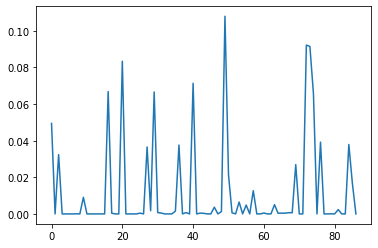

--------Test auc: 0.7822210451977402 for fold 1-------------
                                             
---------------------------------------------
---------------------------------------Training Begining for fold 2-------------------------------
Found maximum hyperparmeter, now work with that
Device used : cuda
Max hy: (4, 0.02, 0.01, 0.95, 10)
FINAL TEST SCORE(max) test auc: 0.772716572504708 test acc: 0.4796747967479675


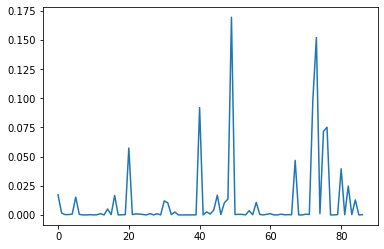

--------Test auc: 0.772716572504708 for fold 2-------------
                                             
---------------------------------------------
---------------------------------------Training Begining for fold 3-------------------------------
Found maximum hyperparmeter, now work with that
Device used : cuda
Max hy: (4, 0.02, 0.01, 0.95, 10)
FINAL TEST SCORE(max) test auc: 0.7786899717514124 test acc: 0.4796747967479675


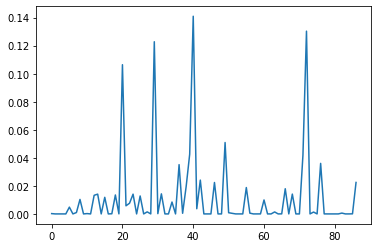

--------Test auc: 0.7786899717514124 for fold 3-------------
                                             
---------------------------------------------
[0.7822210451977402, 0.772716572504708, 0.7786899717514124]
CV mean Test AUC =  0.7778758631512869


,feature name,ratio,feature name,ratio,feature name,ratio
0,Internal.and.External.Comobidity,0.108004,Internal.and.External.Comobidity,0.169442,Depress.CBCL,0.140951
1,PPSP_frequency,0.092236,PPSP_distress,0.152041,PPSP_frequency,0.130316
2,PPSP_distress,0.091485,PPSP_frequency,0.098789,AnxDep.CBCL,0.122776
3,poa_total_6month_follow_up,0.083425,Depress.CBCL,0.091994,poa_total_6month_follow_up,0.106393
4,Depress.CBCL,0.071383,fes_q3,0.075177,Internal.and.External.Comobidity,0.050912
5,nihtbx_cardsort_uncorrected,0.066850,fes_q2,0.071584,TotProb.CBCL,0.042618
6,AnxDep.CBCL,0.066630,poa_total_6month_follow_up,0.057344,totalBAS,0.041943
7,fes_q1,0.065746,DA_baseline,0.046730,fes_q3,0.036032
8,age,0.049417,fes_q7,0.039575,Aggressive.CBCL,0.035134
9,fes_q3,0.039195,fes_q9,0.024726,SomaticPr.CBCL,0.024114


In [26]:
"""
train_data= pd.read_csv('./data/train.ct.csv')
test_data= pd.read_csv('./data/test.ct.csv')
target ='sex'
unused_feat = ['Set', 'subjectkey', 'race.ethnicity', 'abcd_site', 'Unnamed: 0', 'fsqc_qc.y', 'kflod']
Num_FOLDS  = 5
# the number of feature that you want to show 
Num_feat = 5

"""    

hyperparametertuning_CV (train_data, test_data, target, unused_feat, Num_FOLDS, Num_feat)
